# Capstone Project: Traffic Volume Analysis
---
Project notebook organisation:<br>
[1 - EDA and preprocessing](./1_eda_and_preprocessing.ipynb)<br>
**2 - Modelling and insights** (current notebook)<br>
[3 - Appendix](./appendix.ipynb)<br>
<br>
<br>

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import joblib

sns.set_style('ticks')
pd.set_option('display.max_columns', None)

%matplotlib inline

## Introduction
---

<img src='../graphics/modelling_roadmap.png'>

The figure above shows the modelling progression of this project and summarises their results. Due to the profusion of different models, different datasets, and different labels used as the project progressed, and the fact that deep learning models were carried out and stored in Google Colab, in this notebook/repository I will only be presenting the section under Regression (Machine learning), leading up to the formulation fo the production model. The rest of the models can be found in the [appendix notebook](./3_appendix.ipynb).

To first get an idea of if models can differenciate between images of high, medium, and low traffic conditions (i.e., **"how congested?"**) - and whether I needed a different approach to preprocessing - I fitted three different machine learning models (logistic regression, k-nearest neighbours, and decision tree classifier). They were relatively successful, with decently high accuracies as well as good confusion matrix results. Fitting a 9-layer CNN using `Keras` on the same dataset returned an even higher accuracy, of 98%. 

Adding 2 additional layers (1 convolutional and 1 max pooling layer) to the same CNN architecture, I then tested whether models are able to accurately predict the **number of cars** in each image. This model gave an MAE of 3.89, meaning that predictions were off by about 4 cars on average for each image. As the image data is in a sequence (albeit at 1 minute intervals), I also tried two different approaches to adding LSTM to the CNN model. The first, a 12-layer convolutional LSTM, performed much better than the second, a 11-layer ConvLSTM. In the former model, the output of the CNN layers are flattened and then fed into an LSTM layer, while in the latter, the internal matrix multiplications of the LSTM layer are replaced with convolutional operations. However, neither of these LSTM-integrated models outperformed the intial 11-layer CNN.

Attempts to deploy this 11-layer CNN on `Flask` and Heroku were unfortunately unsuccessful, firstly due to an installation error with `Tensorflow`, and then when I converted it to a `PyTorch` model, the slug became too big for Heroku's allowance of 500mb. Numerous online solutions were attempted but have so far been unsuccessful. At this point I decided to go back to machine learning so that I can obtain a deployable model (the deployment process is summarised in the [Deployment section](#Deployment) below). 

A multilinear regression model performed relatively well, with an MAE of 4.58 that was even better than the 11-layer ConvLSTM model. As the relationship between the pixel values and number of cars is not completely linear, I also tried a decision tree model (very overfitted) and then an XGBoost model. The XGBoost model had the best MAE and was selected as the production model.

### Contents

1. [Import data](#Import-data)
2. [Model tuning](#Model-tuning)
3. [Deployment](#Deployment)
4. [Conclusion](#Conclusion)

## Import data
   ---

In [82]:
xtrain = pd.read_pickle('../data/xtrain.zip')
ytrain = pd.read_pickle('../data/ytrain.zip')

xval = pd.read_pickle('../data/xval.zip')
yval = pd.read_pickle('../data/yval.zip')

xtest = pd.read_pickle('../data/xtest.zip')
ytest = pd.read_pickle('../data/ytest.zip')

In [83]:
# get mean pixel values
xtrain_px = xtrain[['image',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]].applymap(lambda x:x.mean())
xtrain_px = xtrain_px.join(xtrain.whites)

xval_px = xval[['image',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]].applymap(lambda x:x.mean())
xval_px = xval_px.join(xval.whites)

xtest_px = xtest[['image',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]].applymap(lambda x:x.mean())
xtest_px = xtest_px.join(xtest.whites)

## Model tuning
---

### Fitting baseline models

#### Linear regression

In [84]:
lr = LinearRegressiongression()

lr.fit(xtrain_px, ytrain[['num_cars']])

ypred_train = lr.predict(xtrain_px)
ypred_val = lr.predict(xval_px)

train_mae = mean_absolute_error(ytrain[['num_cars']], ypred_train)
val_mae = mean_absolute_error(yval[['num_cars']], ypred_val)

print(f"training score: {train_mae}")
print(f"validation score: {val_mae}")

training score: 3.383180240394962
validation score: 4.578035857662058


#### Decision tree

In [86]:
tree = DecisionTreeRegressor(random_state=7, max_depth=5, criterion='mae')

tree.fit(xtrain_px, ytrain[['num_cars']])

ypred_train = tree.predict(xtrain_px)
ypred_val = tree.predict(xval_px)

train_mae = mean_absolute_error(ytrain[['num_cars']], ypred_train)
val_mae = mean_absolute_error(yval[['num_cars']], ypred_val)

print(f"training score: {train_mae}")
print(f"validation score: {val_mae}")

training score: 2.005730659025788
validation score: 5.579691516709511


#### XGBoost

In [87]:
xgb = XGBRegressor(objective='reg:squarederror')

xgb.fit(xtrain_px, ytrain[['num_cars']])

ypred_train = xgb.predict(xtrain_px)
ypred_val = xgb.predict(xval_px)

train_mae = mean_absolute_error(ytrain[['num_cars']], ypred_train)
val_mae = mean_absolute_error(yval[['num_cars']], ypred_val)

print(f"training score: {train_mae}")
print(f"validation score: {val_mae}")

training score: 1.1708936277979767
validation score: 4.750543927472171


### Gridsearch for XGBoost

In [33]:
# define function to return the gs cv scores for the best parameter
def get_mean_gs_cv_score(gs, splits = 5):
    best_param_index = np.where(gs.cv_results_['rank_test_score']==1)[0][0]
    scores = []
    for split in np.arange(splits):
        split_score = gs.cv_results_[f'split{split}_test_score'][best_param_index]
        scores.append(-split_score)
    return scores

In [65]:
# GS iteration 1
xgb = XGBRegressor(objective='reg:squarederror',
                   min_child_weight=1,
                   subsample=0.8,
                   seed=27)

pl = Pipeline([ 
    ('regressor', xgb)
])

params_1 = {
    'regressor__learning_rate': [0.1, 0.3, 0.5],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__colsample_bytree': [0.5, 0.7, 1],
    'regressor__max_depth': [3, 5, 10],
    'regressor__gamma': [0, 0.01, 0.5, 1],
    'regressor__reg_lambda': [1, 2, 5],
    'regressor__reg_alpha': [0,0.5,1.5]
}
     
kf = KFold(5, shuffle = True, random_state = 7)
gs_1 = GridSearchCV(pl, param_grid = params_1, scoring='neg_mean_absolute_error', n_jobs=-2, verbose=True, cv=kf)
gs_1.fit(xtrain_px, ytrain[['num_cars']])

print(f'mean CV score: {get_mean_gs_cv_score(gs_1)}')
print(f'best gridsearch parameters: {gs_1.best_params_}')

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-2)]: Done 845 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-2)]: Done 2345 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-2)]: Done 3674 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-2)]: Done 5024 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 6674 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 8624 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 10476 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done 12176 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-2)]: Done 14076 tasks      | elapsed:  4.7min


mean CV score: [2.607078288282667, 4.490621655327933, 2.9917268718991963, 2.633338626793453, 2.700961570808853]
best gridsearch parameters: {'regressor__colsample_bytree': 0.5, 'regressor__gamma': 1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 0.5, 'regressor__reg_lambda': 2}


[Parallel(n_jobs=-2)]: Done 14580 out of 14580 | elapsed:  5.0min finished


In [66]:
# GS iteration 2
xgb = XGBRegressor(objective='reg:squarederror',
                   min_child_weight=1,
                   subsample=0.8,
                   seed=27,
                   gamma=1,
                   reg_lambda=2,
                   learning_rate=0.1)

pl = Pipeline([ 
    ('regressor', xgb)
])

params_2 = {
    'regressor__n_estimators': [30, 40, 50],
    'regressor__colsample_bytree': [0.3, 0.4, 0.5],
    'regressor__max_depth': [1, 2, 3],
    'regressor__reg_alpha': [0.5, 0.7, 1]
}
     
kf = KFold(5, shuffle = True, random_state = 7)
gs_2 = GridSearchCV(pl, param_grid = params_2, scoring='neg_mean_absolute_error', n_jobs=-2, verbose=True, cv=kf)
gs_2.fit(xtrain_px, ytrain[['num_cars']])

print(f'mean CV score: {get_mean_gs_cv_score(gs_2)}')
print(f'best gridsearch parameters: {gs_2.best_params_}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 146 tasks      | elapsed:    0.8s


mean CV score: [2.599056804180145, 4.25901745728084, 3.0183420589991976, 2.928180858067104, 2.573272946952046]
best gridsearch parameters: {'regressor__colsample_bytree': 0.3, 'regressor__max_depth': 2, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 1}


[Parallel(n_jobs=-2)]: Done 405 out of 405 | elapsed:    1.8s finished


In [67]:
# GS iteration 3
xgb = XGBRegressor(objective='reg:squarederror',
                   min_child_weight=1,
                   subsample=0.8,
                   seed=27,
                   gamma=1,
                   reg_lambda=2,
                   reg_alpha=1,
                   learning_rate=0.1,
                   max_depth=2,
                   n_estimators=50,)

pl = Pipeline([ 
    ('regressor', xgb)
])

params_3 = {
    'regressor__colsample_bytree': [0.1, 0.2, 0.3]
}
     
kf = KFold(5, shuffle = True, random_state = 7)
gs_3 = GridSearchCV(pl, param_grid = params_3, scoring='neg_mean_absolute_error', n_jobs=-2, verbose=True, cv=kf)
gs_3.fit(xtrain_px, ytrain[['num_cars']])

print(f'mean CV score: {get_mean_gs_cv_score(gs_3)}')
print(f'best gridsearch parameters: {gs_3.best_params_}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
mean CV score: [2.599056804180145, 4.25901745728084, 3.0183420589991976, 2.928180858067104, 2.573272946952046]
best gridsearch parameters: {'regressor__colsample_bytree': 0.3}


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  15 out of  15 | elapsed:    0.1s finished


### Evaluation

As seen in the plots below, most of the errors from the XGBoost model are in the form of sudden "spikes" in the number of cars. As mentioned earlier, the background subtraction algorithm performs poorly when there are sudden changes in light regime between consecutive frames. While this was mostly resolved in the LSTM models, the current model is limited in this aspect as it does not include a time component.

The predictions from the model for the test data is also more accurate when the number of cars are low. As there appears to be a consistent pattern in the error (i.e. the model consistently underpredicts the number of cars in the test dataset), this was likely caused by the test set being labelled by a different person than the training and validation sets. When the number of cars are low, the cars are easily discernable and inconsistencies in labelling would not be as high as when there are more cars on the road.

In [88]:
xgb = XGBRegressor(objective='reg:squarederror',
                   min_child_weight=1,
                   subsample=0.8,
                   seed=27,
                   gamma=1,
                   reg_lambda=2,
                   reg_alpha=1,
                   learning_rate=0.1,
                   max_depth=2,
                   n_estimators=50,
                   colsample_bytree=0.3)

xgb.fit(xtrain_px, ytrain[['num_cars']])

ypred_train = xgb.predict(xtrain_px)
ypred_val = xgb.predict(xval_px)
ypred_test = xgb.predict(xtest_px)

train_mae = mean_absolute_error(ytrain[['num_cars']], ypred_train)
val_mae = mean_absolute_error(yval[['num_cars']], ypred_val)
test_mae = mean_absolute_error(ytest[['num_cars']], ypred_test)

print(f"training score: {train_mae}")
print(f"validation score: {val_mae}")
print(f"test score: {test_mae}")

training score: 2.4886321556943876
validation score: 4.423150523615987
test score: 6.589156893332626


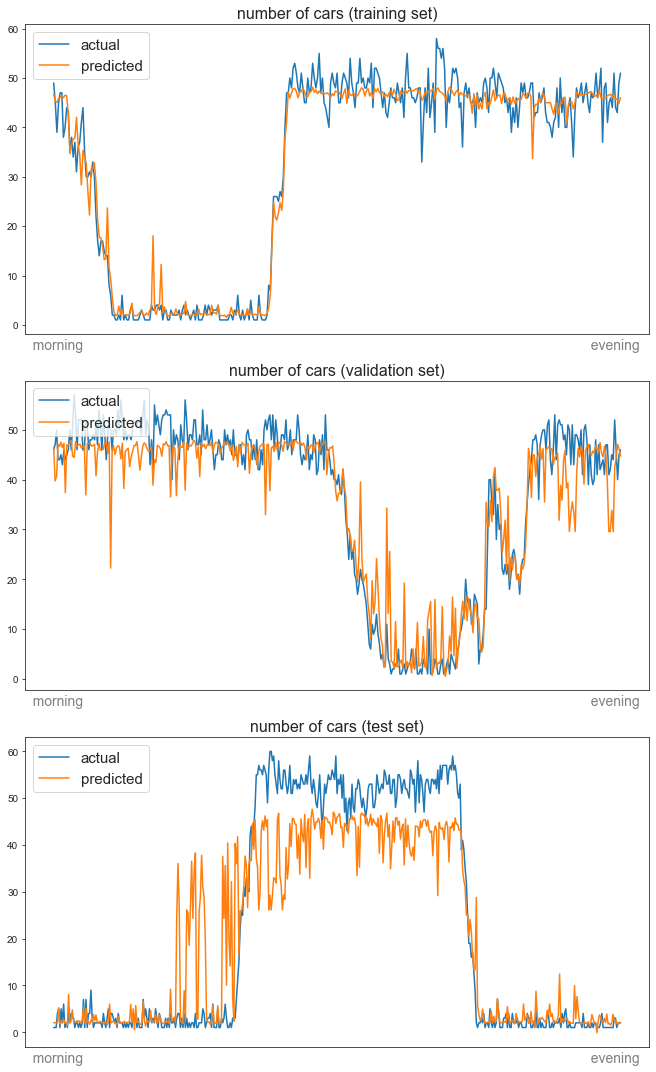

In [119]:
results_train = pd.DataFrame({'actual':ytrain.num_cars.values, 
                              'predicted':ypred_train.reshape(len(ypred_train),)})
results_val = pd.DataFrame({'actual':yval.num_cars.values, 
                             'predicted':ypred_val.reshape(len(ypred_val),)})
results_test = pd.DataFrame({'actual':ytest.num_cars.values, 
                             'predicted':ypred_test.reshape(len(ypred_test),)})

# plot actual vs predicted values
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10,15))
ax1.plot(results_train.actual, label='actual')
ax1.plot(results_train.predicted, label='predicted')
ax1.set_title("number of cars (training set)", fontsize=16)
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1.set_xlabel("  morning                                                                                                                                   evening", 
               position = (0,0), ha = 'left', fontsize = 14, color = 'grey')
ax1.legend(prop={'size': 15}, loc = 2)

ax2.plot(results_val.actual, label='actual')
ax2.plot(results_val.predicted, label='predicted')
ax2.set_title("number of cars (validation set)", fontsize=16)
ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax2.set_xlabel("  morning                                                                                                                                   evening", 
               position = (0,0), ha = 'left', fontsize = 14, color = 'grey')
ax2.legend(prop={'size': 15}, loc = 2)

ax3.plot(results_test.actual, label='actual')
ax3.plot(results_test.predicted, label='predicted')
ax3.set_title("number of cars (test set)", fontsize=16)
ax3.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax3.set_xlabel("  morning                                                                                                                                   evening", 
               position = (0,0), ha = 'left', fontsize = 14, color = 'grey')
ax3.legend(prop={'size': 15}, loc = 2)
plt.tight_layout()

### Export production model

In [76]:
joblib.dump(xgb, '../model/xgb.model') 

['../model/xgb.model']

## Deployment
---

<img src='../graphics/deployment.png' width=300>

The figure above summarises the deployment architecture. In short, I built two apps on Heroku, both of which sits on the same PostgreSQL server. The scraping app makes repeated calls to the LTA API at 1 minute intervals and stores the images in the server. The web app pulls out the latest images from the server, which are then preprocessed and fed into the model. The prediction is then shown on the UI. 

The web app and the UI are still a work in progress, but the current proof of concept can be viewed on https://sgcheckpoints.herokuapp.com/. The source code is in https://github.com/zzeniale/traffic-app. 

## Conclusion
---

The current model extracts the number of cars from traffic images with relatively high accuracy, thus providing a direct estimation of road congestion in contrast to the proxy-based model used by Google Maps, which bases their traffic information on a combination of real-time data sent by smartphones and historic travel times. However, what this model lacks is the ability to estimate travel times. The two approaches should therefore be considered complementary, and could be combined for a more well-rounded application that provides better recommendations to commuters.

The biggest limitation with the current approach to modelling traffic is that it produces a model that cannot be generalised to images from other cameras. Due to the low image qualities that hinders the training of an object detection model, the current model relies on a somewhat primitive approach of manual car labelling. As each traffic camera is angled differently with regards to the cars on the road, they each produce images with different patterns of occlusion. Therefore, a model trained on labelled images from one camera would not be able to accurately predict the number of cars in images from a camera at a different angle or location. 

As such, there is still much room for improvement and expansion of the current project. Possiblities include but are not limited to:

**Model improvements**
- include timeseries elements to reduce the occurrence of fluctuations in predictions due to changes in lighting (RNN would also solve this problem...if Tensorflow/anyone ever comes up with a solution for the [problem I'm facing](https://github.com/tensorflow/tensorflow/issues/34607#issue-528543048) with deployment)
- adapting crowd counting models - as the math behind these are too difficult for me to understand at the moment, I'm currently unable to incorporate it into this project
- expansion of model to include night-time data (which would likely require a different model)

**UI/deployment improvements**
- alert system for when traffic starts to increase
- make predictions on how long a jam is likely to last (this would require more historical data and a bigger database)
- display a trendline of car counts over time, which should show both real time and historical data
- account for situations where the model would not be able to work, such as when there is almost zero visibility during heavy rains (perhaps by filling in with historical data, when there is a bigger database of images)